In [1]:
import tensorflow as tf
from tensorflow.keras import datasets,layers,models,optimizers

In [2]:
class LeNet:
    def build(input_shape,classes):
        model=models.Sequential()
        model.add(layers.Convolution2D(20,(5,5),activation='relu',input_shape=input_shape))
        model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
        
        
        model.add(layers.Convolution2D(20,(5,5),activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
        
        model.add(layers.Flatten())
        model.add(layers.Dense(500,activation='relu'))
        model.add(layers.Dense(classes,activation='softmax'))
        return model

In [3]:
Epocha=5
batch_size=128
verbose=1
optimizer=tf.keras.optimizers.Adam()
validation_split=0.90

In [4]:
img_rows,img_cols=28,28 ## input image dimenstions
input_shape=(img_rows,img_cols,1)
nb_classes=10

In [5]:
(x_train,y_train),(x_test,y_test)=datasets.mnist.load_data()

In [6]:
x_train=x_train.reshape((60000,28,28,1))
x_test=x_test.reshape((10000,28,28,1))

In [7]:
x_train,x_test=x_train/255.0,x_test/255.0

In [10]:
!pip install d2l==0.16.0

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 76 kB 671 kB/s eta 0:00:011


In [36]:
from d2l import tensorflow as d2l
import tensorflow as tf

In [37]:
def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6,kernel_size=3,activation='relu',padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=2,strides=2),
        tf.keras.layers.Conv2D(filters=6,kernel_size=3,activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2,strides=2),
        tf.keras.layers.Conv2D(filters=6,kernel_size=3,activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2,strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120,activation='relu'),
        tf.keras.layers.Dense(84,activation='softmax'),
        tf.keras.layers.Dense(10)])

In [38]:
x=tf.random.uniform((1,28,28,1))
for layer in net().layers:
    x=layer(x)
    print(layer.__class__.__name__,'output_shape:\t', x.shape)

Conv2D output_shape:	 (1, 28, 28, 6)
MaxPooling2D output_shape:	 (1, 14, 14, 6)
Conv2D output_shape:	 (1, 12, 12, 6)
MaxPooling2D output_shape:	 (1, 6, 6, 6)
Conv2D output_shape:	 (1, 4, 4, 6)
MaxPooling2D output_shape:	 (1, 2, 2, 6)
Flatten output_shape:	 (1, 24)
Dense output_shape:	 (1, 120)
Dense output_shape:	 (1, 84)
Dense output_shape:	 (1, 10)


In [39]:
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size=batch_size)

In [40]:
class TrainCallback(tf.keras.callbacks.Callback):
    def __init__(self,net,train_iter,test_iter,num_epoches,device_name):
        self.timer=d2l.Timer()
        self.animator=d2l.Animator(
                 xlabel='epoch', xlim=[1,num_epoches], legend=['train_loss','train_accuracy','test_accuracy'])
        self.net=net
        self.train_iter=train_iter
        self.test_iter=test_iter
        self.num_epoches=num_epoches
        self.device_name=device_name
        
    def on_epoch_begin(self,epoch,logs=None):
        self.timer.start()
    
    def on_epoch_end(self,epoch,logs=None):
        self.timer.stop()
        test_accuracy=self.net.evaluate(
            self.test_iter,verbose=0,return_dict=True)['accuracy']
        metrics=(logs['loss'],logs['accuracy'],test_accuracy)
        self.animator.add(epoch+1,metrics)
        
        if epoch -- self.num_epoches-1:
            batch_size=next(iter(self.train_iter))[0].shape[0]
            num_examples=batch_size*tf.data.experimental.cardinality(
                self.train_iter).numpy()
        print(f'loss {metrics[0]:.3f}, train_accuracy {metrics[1]:.3f}',f'test_accuracy {metrics[2]:.3f}')
            
        print(f'{num_examples/self.timer.avg():.1f} exapmples/ sec on'
                   f'{str(self.device_name)}')

  

In [41]:
  ## Saving the model
def train_ch6(net_fn,train_iter,test_iter,num_epoches,lr,device=d2l.try_gpu()):
    device_name=device._device_name
    strategy=tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer=tf.keras.optimizers.SGD(learning_rate=lr)
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net=net_fn()
            
        net.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
            
        callback=TrainCallback(net,train_iter,test_iter,num_epoches,device_name)
        net.fit(train_iter,epochs=num_epoches,verbose=0,callbacks=[callback])
        
        
        return net

loss 2.304, train_accuracy 0.099 test_accuracy 0.100
8035.4 exapmples/ sec on/CPU:0


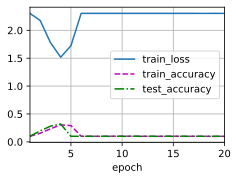

In [42]:
lr,num_epochs=0.9,20
train_ch6(net,train_iter,test_iter,num_epochs,lr)